In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [3]:
from datasets import load_dataset

# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

In [4]:
# Split training data into train and validation tensorflow datasets

datasets = dataset.train_test_split(test_size=0.2)
ds_train_ = datasets["train"].to_tf_dataset(columns='image', shuffle=True, label_cols='label')
ds_valid_ = datasets["test"].to_tf_dataset(columns='image', shuffle=False, label_cols='label')

In [5]:
alzheimers_state = {
    0 : "No Degeneration",
    1 : "Mild Degeneration",
    2 : "Moderate Degeneration",
    3 : "Severe Degeneration"
}

In [6]:
# Data Pipeline
# Converts image to float, and add one grayscale channel
def preprocess(image, label):
    image = tf.expand_dims(image, axis=-1)  # Shape becomes (128, 128, 1)
    image = tf.image.grayscale_to_rgb(image) # Shape become (128, 128, 3)
    
    image = tf.cast(image, tf.float32)
    # Normalize pixel values to [0, 1]
    image /= 255.0
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

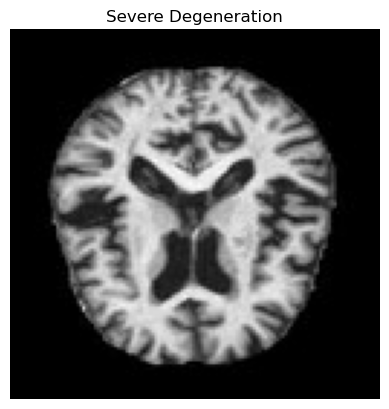

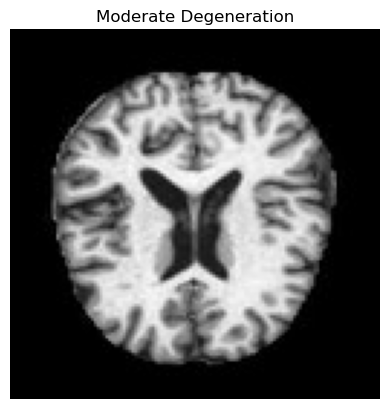

In [7]:
# Take a look at some of our sample MRI data
for image, label in ds_train.take(2): 
    # Convert image to numpy array and display with matplotlib 
    plt.imshow(image.numpy()) # Convert TensorFlow tensor to a NumPy array
    plt.title(alzheimers_state[label.numpy()]) # Print label
    plt.axis('off')
    plt.show()

In [8]:
# Batch our datasets
ds_train_batched = ds_train.batch(batch_size=64)
ds_valid_batched = ds_valid.batch(batch_size=64)

In [9]:
# import VGG16 pretrained base
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable =False

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dense(4, activation='softmax'),
])

In [12]:
input_shape = (64, 128, 128, 3) # shape of the input data
model.build(input_shape) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 15,239,300
Trainable params: 524,612
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
model.compile(
    optimizer='adam',
     # Labels are integers 0-3, use sparse categorical crossentropy for loss function
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)


In [14]:
from tensorflow.keras import callbacks
earlystopping = callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    restore_best_weights=True)

history = model.fit(
    ds_train_batched,
    validation_data=ds_valid_batched,
    epochs=60,
    verbose=True,
    callbacks=[earlystopping]
)

Epoch 1/60


2024-12-21 18:17:14.508047: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_2.


64/64 [==============================] - 37s 565ms/step - loss: 1.5206 - accuracy: 0.5061 - val_loss: 1.0411 - val_accuracy: 0.6201
Epoch 2/60
64/64 [==============================] - 25s 393ms/step - loss: 1.0211 - accuracy: 0.5852 - val_loss: 0.9666 - val_accuracy: 0.6289
Epoch 3/60
64/64 [==============================] - 25s 398ms/step - loss: 0.9572 - accuracy: 0.6104 - val_loss: 0.9215 - val_accuracy: 0.6406
Epoch 4/60
64/64 [==============================] - 27s 416ms/step - loss: 0.9235 - accuracy: 0.6194 - val_loss: 0.8970 - val_accuracy: 0.6543
Epoch 5/60
64/64 [==============================] - 27s 423ms/step - loss: 0.9017 - accuracy: 0.6270 - val_loss: 0.8803 - val_accuracy: 0.6553
Epoch 6/60
64/64 [==============================] - 27s 425ms/step - loss: 0.8860 - accuracy: 0.6343 - val_loss: 0.8676 - val_accuracy: 0.6572
Epoch 7/60
64/64 [==============================] - 27s 426ms/step - loss: 0.8736 - accuracy: 0.6396 - val_loss: 0.8576 - val_accuracy: 0.6670
Epoch 8/60

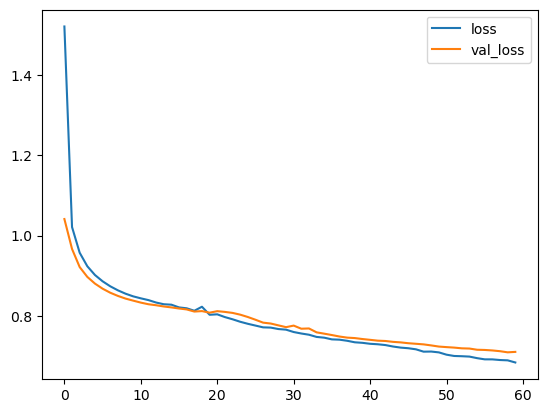

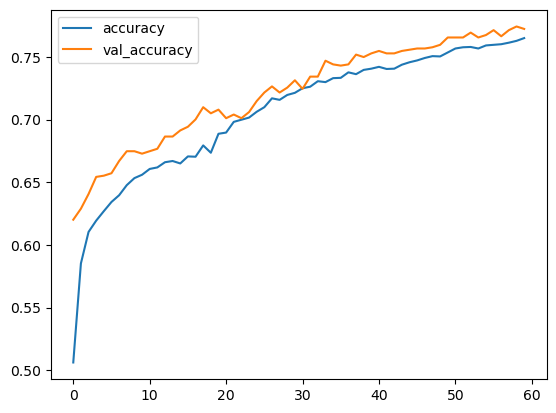

In [18]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [19]:
# Load the Falah/Alzheimer_MRI dataset

ds_test_ = load_dataset('Falah/Alzheimer_MRI', split='test')
# Generate predictions from the test dataset
ds_test_ = ds_test_.to_tf_dataset(columns='image', shuffle=False, label_cols='label')

ds_test = (
    ds_test_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
    .batch(batch_size=64)
)

predictions = model.predict(ds_test)

# Convert probabilities to class predictions
predicted_classes = tf.argmax(predictions, axis=1).numpy()

# Extract true labels from the test dataset
true_classes = tf.concat([label for image, label in ds_test], axis=0).numpy()

Using the latest cached version of the dataset since Falah/Alzheimer_MRI couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/nicopoliczer/.cache/huggingface/datasets/Falah___alzheimer_mri/default/0.0.0/daac24f9597236b45837d82f7eb9c9ad1f8c60c8 (last modified on Sat Dec 21 18:17:12 2024).


20/20 [==============================] - 11s 582ms/step


In [20]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_classes, predicted_classes, labels=(0,1,2,3), target_names=("No Alzheimers", "Mild", "Moderate", "Severe"))
print(report)

               precision    recall  f1-score   support

No Alzheimers       0.77      0.45      0.57       172
         Mild       0.00      0.00      0.00        15
     Moderate       0.76      0.85      0.80       634
       Severe       0.69      0.71      0.70       459

     accuracy                           0.74      1280
    macro avg       0.56      0.50      0.52      1280
 weighted avg       0.73      0.74      0.73      1280



/Users/nicopoliczer/miniconda3/envs/alzheimers_mri/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nicopoliczer/miniconda3/envs/alzheimers_mri/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nicopoliczer/miniconda3/envs/alzheimers_mri/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

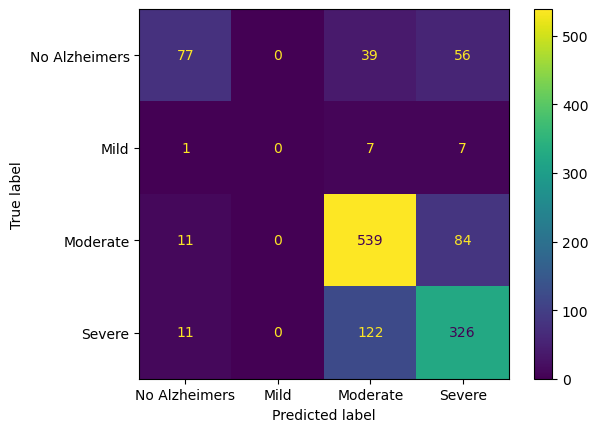

In [27]:
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate confusion matrix
confusion_matrix = metrics.confusion_matrix(true_classes, predicted_classes, labels=(0,1,2,3))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=("No Alzheimers", "Mild", "Moderate", "Severe"))
disp.plot()
plt.show()

In [28]:
model.save('model/alzheimers_mri_predict_model')

INFO:tensorflow:Assets written to: model/alzheimers_mri_predict_model/assets


INFO:tensorflow:Assets written to: model/alzheimers_mri_predict_model/assets
